In [1]:
from KRData.HKData import HKFuture
import pandas as pd

In [2]:
import datetime as dt
import talib

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


d:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
hf = HKFuture('krdata', 'kairuitouzi')

In [4]:
trade_dates = hf.get_main_contract_trade_dates('HSI', '20110101', '20190401')

In [5]:
K = 0
def HLStrategy(df):
    global K
    _open=[]
    _close=[]
    _type = ''
    _openH = 0
    _range = 0
    _std = 0
    
    df = df.between_time('9:15', '16:30')
    if len(df)<60:
        return _open, _close, _type, _openH, _range, 0, 0, 0, 0
    
    _openH = df.iloc[0]['open'] - df.iloc[0]['last_close']
    df = df.iloc[6:]
    open_time = df.iloc[0]['datetime']
    first_hour: pd.DataFrame = df.iloc[:60]
    rest_trading = df.iloc[61:]
    upPrice = first_hour.close.max()
    upPrice_time = first_hour.close.idxmax()
    downPrice = first_hour.close.min()
    downPrice_time = first_hour.close.idxmin()
    _std = first_hour.iloc[-1].std_60
    HT = (upPrice_time - open_time).total_seconds() // 60
    LT = (downPrice_time - open_time).total_seconds() // 60
    _range = upPrice - downPrice
    if upPrice_time > downPrice_time:
        _type = 'LH'
    else:
        _type = 'HL'
    
    fix_stoploss = (upPrice - downPrice) * K
    
    if fix_stoploss < 40:
        fix_stoploss = 40
    elif fix_stoploss > 220:
        fix_stoploss = 220
    
    pos = 0
    TH = rest_trading.iloc[0]['close']
    TL = rest_trading.iloc[0]['close']
    

    for d, bar in rest_trading.iterrows():
        if pos == 0:
            if bar.close > upPrice:
                _open = [bar.datetime, 'Long', bar.close]
                _type = 'LHL' if _type=='LH' else 'HLL'
                pos += 1
            elif bar.close < downPrice:
                _open = [bar.datetime, 'Short', bar.close]
                _type = 'LHS' if _type=='LH' else 'HLS'
                pos -= 1
        else:
            if pos > 0:
                if TH - bar.close > fix_stoploss :
                    _close = [bar.datetime, 'Short', bar.close]
                    pos -= 1
                    break
            elif pos  < 0:
                if bar.close - TL > fix_stoploss:
                    _close = [bar.datetime, 'Long', bar.close]
                    pos += 1
                    break
        TH = max(bar.close, TH)
        TL = min(bar.close, TL)
    else:
        if pos > 0:
            _close = [bar.datetime, 'Short', bar.close]
            pos -= 1
        elif pos < 0:
            _close = [bar.datetime, 'Long', bar.close]
            pos += 1

    
    return _open, _close, _type, _openH, _range, HT, LT, _std
    
    

In [6]:
total_trade_results = {}
for i in [0.5, 0.6, 0.7, 0.8]:
    K = i
    trade_results = []
    for code, tds in trade_dates.items():
        print(f'Backtest{code}- From:{tds[0]} To:{tds[-1]}')
        s = tds[0]
        e = tds[-1]
        df = hf.get_bars(code, fields=['datetime', 'open', 'high', 'low', 'close', 'trade_date'], start=s, end=e)
        df['std_5'] = talib.STDDEV(df['close'].values, timeperiod=5)
    #     df['std_5'] = 0
        df['std_60'] = talib.STDDEV(df['close'].values, timeperiod=60)
        df['last_close'] = df['close'].shift(1)
        trade_result = df.groupby('trade_date').apply(HLStrategy)
        trade_results.append(trade_result)
    else:
        total_results = pd.concat(trade_results)
        total_trade_results[K] = total_results

BacktestHSI1101- From:2011-01-03 00:00:00 To:2011-01-28 00:00:00
BacktestHSI1102- From:2011-01-31 00:00:00 To:2011-02-25 00:00:00
BacktestHSI1103- From:2011-02-28 00:00:00 To:2011-03-30 00:00:00
BacktestHSI1104- From:2011-03-31 00:00:00 To:2011-04-28 00:00:00
BacktestHSI1105- From:2011-04-29 00:00:00 To:2011-05-30 00:00:00
BacktestHSI1106- From:2011-05-31 00:00:00 To:2011-06-29 00:00:00
BacktestHSI1107- From:2011-06-30 00:00:00 To:2011-07-28 00:00:00
BacktestHSI1108- From:2011-07-29 00:00:00 To:2011-08-30 00:00:00
BacktestHSI1109- From:2011-08-31 00:00:00 To:2011-09-30 00:00:00
BacktestHSI1110- From:2011-10-03 00:00:00 To:2011-10-28 00:00:00
BacktestHSI1111- From:2011-10-31 00:00:00 To:2011-11-29 00:00:00
BacktestHSI1112- From:2011-11-30 00:00:00 To:2011-12-29 00:00:00
BacktestHSI1201- From:2011-12-30 00:00:00 To:2012-01-30 00:00:00
BacktestHSI1202- From:2012-01-31 00:00:00 To:2012-02-28 00:00:00
BacktestHSI1203- From:2012-02-29 00:00:00 To:2012-03-29 00:00:00
BacktestHSI1204- From:201

BacktestHSI1304- From:2013-03-28 00:00:00 To:2013-04-29 00:00:00
BacktestHSI1305- From:2013-04-30 00:00:00 To:2013-05-30 00:00:00
BacktestHSI1306- From:2013-05-31 00:00:00 To:2013-06-27 00:00:00
BacktestHSI1307- From:2013-06-28 00:00:00 To:2013-07-30 00:00:00
BacktestHSI1308- From:2013-07-31 00:00:00 To:2013-08-29 00:00:00
BacktestHSI1309- From:2013-08-30 00:00:00 To:2013-09-27 00:00:00
BacktestHSI1310- From:2013-09-30 00:00:00 To:2013-10-30 00:00:00
BacktestHSI1311- From:2013-10-31 00:00:00 To:2013-11-28 00:00:00
BacktestHSI1312- From:2013-11-29 00:00:00 To:2013-12-30 00:00:00
BacktestHSI1401- From:2013-12-31 00:00:00 To:2014-01-29 00:00:00
BacktestHSI1402- From:2014-01-30 00:00:00 To:2014-02-27 00:00:00
BacktestHSI1403- From:2014-02-28 00:00:00 To:2014-03-28 00:00:00
BacktestHSI1404- From:2014-03-31 00:00:00 To:2014-04-29 00:00:00
BacktestHSI1405- From:2014-04-30 00:00:00 To:2014-05-29 00:00:00
BacktestHSI1406- From:2014-05-30 00:00:00 To:2014-06-27 00:00:00
BacktestHSI1407- From:201

BacktestHSI1507- From:2015-06-30 00:00:00 To:2015-07-30 00:00:00
BacktestHSI1508- From:2015-07-31 00:00:00 To:2015-08-28 00:00:00
BacktestHSI1509- From:2015-08-31 00:00:00 To:2015-09-29 00:00:00
BacktestHSI1510- From:2015-09-30 00:00:00 To:2015-10-29 00:00:00
BacktestHSI1511- From:2015-10-30 00:00:00 To:2015-11-27 00:00:00
BacktestHSI1512- From:2015-11-30 00:00:00 To:2015-12-30 00:00:00
BacktestHSI1601- From:2015-12-31 00:00:00 To:2016-01-28 00:00:00
BacktestHSI1602- From:2016-01-29 00:00:00 To:2016-02-26 00:00:00
BacktestHSI1603- From:2016-02-29 00:00:00 To:2016-03-30 00:00:00
BacktestHSI1604- From:2016-03-31 00:00:00 To:2016-04-28 00:00:00
BacktestHSI1605- From:2016-04-29 00:00:00 To:2016-05-30 00:00:00
BacktestHSI1606- From:2016-05-31 00:00:00 To:2016-06-29 00:00:00
BacktestHSI1607- From:2016-06-30 00:00:00 To:2016-07-28 00:00:00
BacktestHSI1608- From:2016-07-29 00:00:00 To:2016-08-30 00:00:00
BacktestHSI1609- From:2016-08-31 00:00:00 To:2016-09-29 00:00:00
BacktestHSI1610- From:201

BacktestHSI1710- From:2017-09-29 00:00:00 To:2017-10-30 00:00:00
BacktestHSI1711- From:2017-10-31 00:00:00 To:2017-11-29 00:00:00
BacktestHSI1712- From:2017-11-30 00:00:00 To:2017-12-28 00:00:00
BacktestHSI1801- From:2017-12-29 00:00:00 To:2018-01-30 00:00:00
BacktestHSI1802- From:2018-01-31 00:00:00 To:2018-02-27 00:00:00
BacktestHSI1803- From:2018-02-28 00:00:00 To:2018-03-28 00:00:00
BacktestHSI1804- From:2018-03-29 00:00:00 To:2018-04-27 00:00:00
BacktestHSI1805- From:2018-04-30 00:00:00 To:2018-05-30 00:00:00
BacktestHSI1806- From:2018-05-31 00:00:00 To:2018-06-28 00:00:00
BacktestHSI1807- From:2018-06-29 00:00:00 To:2018-07-30 00:00:00
BacktestHSI1808- From:2018-07-31 00:00:00 To:2018-08-30 00:00:00
BacktestHSI1809- From:2018-08-31 00:00:00 To:2018-09-27 00:00:00
BacktestHSI1810- From:2018-09-28 00:00:00 To:2018-10-30 00:00:00
BacktestHSI1811- From:2018-10-31 00:00:00 To:2018-11-29 00:00:00
BacktestHSI1812- From:2018-11-30 00:00:00 To:2018-12-28 00:00:00
BacktestHSI1901- From:201

In [25]:
def calc(result):
    total_pnl = 0
    total_count = 0
    lost_pnl = 0
    lost_count = 0
    gain_pnl = 0
    gain_count = 0
    pnl_list = []
    for d, r in result.items():
        if r[0] and r[1]:
            _open = -r[0][2] if r[0][1] == 'Long' else r[0][2]
            _close = -r[1][2] if r[1][1] == 'Long' else r[1][2]
            pnl = _close + _open
            pnl_list.append([d, pnl, r[2], r[3], r[4], r[7]])
            if pnl <0:
                lost_pnl += pnl
                lost_count += 1
            else:
                gain_pnl += pnl
                gain_count += 1
    total_pnl = gain_pnl + lost_pnl
    total_count = gain_count + lost_count
    win_rate = gain_count /total_count
    pnl_rate = abs((gain_pnl/gain_count)/(lost_pnl/lost_count))
    pnl_df = pd.DataFrame([p for p in pnl_list], columns=['datetime', 'pnl', '_type', '_openH', '_range', '_std']).set_index('datetime')
    return {'胜率': win_rate, '盈亏比': pnl_rate, '总净盈利': [total_pnl, total_count], '总亏损':[lost_pnl, lost_count], '总盈利': [gain_pnl, gain_count]}, pnl_df

In [35]:
for k, v in total_trade_results.items():
    print(k, calc(v)[0])

0.5 {'胜率': 0.41773504273504275, '盈亏比': 1.8065496258189113, '总净盈利': [15464.0, 1872], '总亏损': [-52230.0, 1090], '总盈利': [67694.0, 782]}
0.6 {'胜率': 0.43002136752136755, '盈亏比': 1.6579185971437567, '总净盈利': [14690.0, 1872], '总亏损': [-58568.0, 1067], '总盈利': [73258.0, 805]}
0.7 {'胜率': 0.4375, '盈亏比': 1.624037693082227, '总净盈利': [16651.0, 1872], '总亏损': [-63278.0, 1053], '总盈利': [79929.0, 819]}
0.8 {'胜率': 0.4481837606837607, '盈亏比': 1.5815750576624843, '总净盈利': [19224.0, 1872], '总亏损': [-67559.0, 1033], '总盈利': [86783.0, 839]}


In [37]:
pnl_values.cumsum()

datetime
2011-01-03       20.0
2011-01-04      133.0
2011-01-05      156.0
2011-01-06       68.0
2011-01-07      -56.0
2011-01-10       40.0
2011-01-11      142.0
2011-01-12      365.0
2011-01-13      252.0
2011-01-14      227.0
2011-01-17      207.0
2011-01-18      223.0
2011-01-19      189.0
2011-01-20      210.0
2011-01-21      119.0
2011-01-24      122.0
2011-01-25       60.0
2011-01-26      140.0
2011-01-27       11.0
2011-01-31      -46.0
2011-02-02       25.0
2011-02-07      354.0
2011-02-08      317.0
2011-02-09      478.0
2011-02-10      652.0
2011-02-11      757.0
2011-02-14      798.0
2011-02-15      795.0
2011-02-16      906.0
2011-02-17      862.0
               ...   
2019-02-19    19362.0
2019-02-20    19186.0
2019-02-21    19190.0
2019-02-22    19414.0
2019-02-25    19309.0
2019-02-26    19384.0
2019-02-27    19325.0
2019-02-28    19142.0
2019-03-01    19133.0
2019-03-04    19452.0
2019-03-05    19460.0
2019-03-06    19418.0
2019-03-07    19316.0
2019-03-08    19283.0
2

0.5 最大回撤开始:2018-06-19 00:00:00 最大回撤结束:2018-11-06 00:00:00 最大回撤:1192.0
0.5 最长回撤持续开始:2015-08-24 00:00:00 最长回撤持续结束:2016-10-07 00:00:00 最长回撤时间: 410 days 00:00:00
0.5 MaxDrawdown: 1192.0   MaxDrawdown_time: [Timestamp('2018-06-19 00:00:00'), Timestamp('2018-11-06 00:00:00')]
0.6 最大回撤开始:2015-08-24 00:00:00 最大回撤结束:2016-08-31 00:00:00 最大回撤:1598.0
0.6 最长回撤持续开始:2015-08-24 00:00:00 最长回撤持续结束:2017-03-14 00:00:00 最长回撤时间: 568 days 00:00:00
0.6 MaxDrawdown: 1598.0   MaxDrawdown_time: [Timestamp('2015-08-24 00:00:00'), Timestamp('2016-08-31 00:00:00')]
0.7 最大回撤开始:2016-02-03 00:00:00 最大回撤结束:2016-06-13 00:00:00 最大回撤:1584.0
0.7 最长回撤持续开始:2016-02-03 00:00:00 最长回撤持续结束:2016-10-07 00:00:00 最长回撤时间: 247 days 00:00:00
0.7 MaxDrawdown: 1584.0   MaxDrawdown_time: [Timestamp('2016-02-03 00:00:00'), Timestamp('2016-06-13 00:00:00')]
0.8 最大回撤开始:2016-01-29 00:00:00 最大回撤结束:2016-06-13 00:00:00 最大回撤:2022.0
0.8 最长回撤持续开始:2016-01-29 00:00:00 最长回撤持续结束:2017-02-28 00:00:00 最长回撤时间: 396 days 00:00:00
0.8 MaxDrawdown: 2022.0   Max

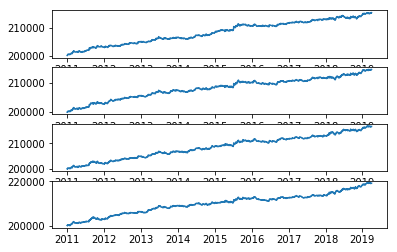

In [74]:
n = 0
pnl_ax = []
for k, v in total_trade_results.items():
    pnl_values = calc(v)[1]['pnl']
    portfolio_value = pnl_values.cumsum() + 200000  # 设置一个很大的初始资金来防止计算回撤发生误差
    xs = portfolio_value.values
#     rt = portfolio.unit_net_value.values
    max_dd_end = np.argmax(np.maximum.accumulate(xs) / xs)
    if max_dd_end == 0:
        max_dd_end = len(xs) - 1
    max_dd_start = np.argmax(xs[:max_dd_end]) if max_dd_end > 0 else 0

    # maxdrawdown duration
    al_cum = np.maximum.accumulate(xs)
    a = np.unique(al_cum, return_counts=True)
    start_idx = np.argmax(a[1])
    m = a[0][start_idx]
    al_cum_array = np.where(al_cum == m)
    max_ddd_start_day = al_cum_array[0][0]
    max_ddd_end_day = al_cum_array[0][-1]
    
    print(k, f'最大回撤开始:{portfolio_value.index[max_dd_start]} 最大回撤结束:{portfolio_value.index[max_dd_end]} 最大回撤:{portfolio_value[max_dd_start] - portfolio_value[max_dd_end]}')
    print(k, f'最长回撤持续开始:{pnl_values.index[max_ddd_start_day]} 最长回撤持续结束:{pnl_values.index[max_ddd_end_day]} 最长回撤时间: {pnl_values.index[max_ddd_end_day] - pnl_values.index[max_ddd_start_day]}')
    n += 1
    ax = plt.subplot(len(total_trade_results), 1, n)
    ax.plot(portfolio_value)
    pnl_ax.append(ax)
#     ax.plot([max_dd_start, max_dd_start], [portfolio_value.min(), portfolio_value.max()])
    total = 0
    Max = 0
    MaxDrawdown = 0
    for t, p in pnl_values.items():
        total += p
        if total > Max:
            Max = total
            Max_time = t
            
        if Max - total > MaxDrawdown:
            MaxDrawdown = Max - total
            MaxDrawdown_period = [Max_time, t]
    print(k, 'MaxDrawdown:', MaxDrawdown, '  MaxDrawdown_time:', MaxDrawdown_period)
    

In [56]:
plt.plot?

In [11]:
df=pd.DataFrame(pnl_list, columns=['date', 'pnl', '_type', '_openH', '_range', '_std']).set_index('date')

In [12]:
df

,pnl,_type,_openH,_range,_std
date,,,,,
2011-01-03,20.0,LHL,NaN,277.0,67.119338
2011-01-04,113.0,LHL,7.0,145.0,45.631528
2011-01-05,23.0,LHL,-66.0,117.0,30.794678
2011-01-06,-88.0,HLS,83.0,91.0,24.162275
2011-01-07,-124.0,LHL,-15.0,139.0,29.863002
2011-01-10,96.0,HLS,-79.0,153.0,44.703157
2011-01-11,102.0,HLL,68.0,115.0,28.416598
2011-01-12,223.0,LHL,64.0,138.0,37.706450
2011-01-13,-113.0,LHS,104.0,128.0,27.348857


In [13]:
grouped_by_openH = df.groupby(pd.cut(df['_openH'], bins=20))
grouped_bt_range = df.groupby(pd.cut(df['_range'], bins=20))
grouped_bt_range = df.groupby(pd.cut(df['_std'], bins=20))

In [14]:
df['group_openH'] = pd.cut(df['_openH'], bins=10)
df['group_range'] = pd.cut(df['_range'], bins=20)
df['group_std'] = pd.cut(df['_std'], bins=20)

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


d:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


_openH
(-1311.248, -1264.04]    631.000000
(-1264.04, -1219.08]            NaN
(-1219.08, -1174.12]            NaN
(-1174.12, -1129.16]            NaN
(-1129.16, -1084.2]      -29.000000
(-1084.2, -1039.24]             NaN
(-1039.24, -994.28]             NaN
(-994.28, -949.32]              NaN
(-949.32, -904.36]       -22.000000
(-904.36, -859.4]        -23.000000
(-859.4, -814.44]               NaN
(-814.44, -769.48]              NaN
(-769.48, -724.52]      -195.000000
(-724.52, -679.56]              NaN
(-679.56, -634.6]               NaN
(-634.6, -589.64]       -151.000000
(-589.64, -544.68]      -173.000000
(-544.68, -499.72]       103.666667
(-499.72, -454.76]        11.500000
(-454.76, -409.8]        -18.800000
(-409.8, -364.84]         36.875000
(-364.84, -319.88]       -38.571429
(-319.88, -274.92]       -20.307692
(-274.92, -229.96]       -18.100000
(-229.96, -185.0]         40.682927
(-185.0, -140.04]         14.524590
(-140.04, -95.08]        -10.889908
(-95.08, -50.12]     

<Container object of 50 artists>

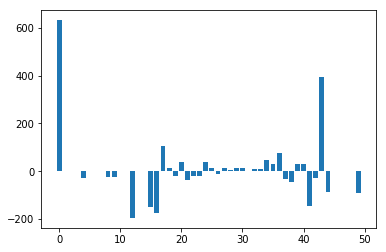

In [16]:
grouped_by_openH = df.groupby(pd.cut(df['_openH'], bins=50))
print(grouped_by_openH.pnl.mean())
plt.bar(range(len(grouped_by_openH.pnl.mean())),grouped_by_openH.pnl.mean())
# 开盘区间选择-500至 350之间最佳

<Container object of 50 artists>

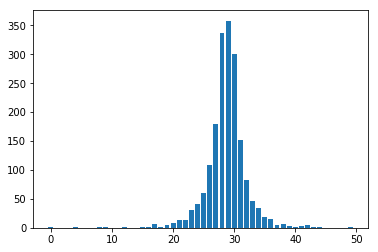

In [17]:
plt.bar(range(len(grouped_by_openH.pnl.mean())),grouped_by_openH.pnl.count())

_range
(41.789, 67.22]        20.551724
(67.22, 91.44]          8.436364
(91.44, 115.66]        -0.539877
(115.66, 139.88]       17.131833
(139.88, 164.1]        -2.255814
(164.1, 188.32]        16.278107
(188.32, 212.54]       35.194915
(212.54, 236.76]        1.812500
(236.76, 260.98]        3.084746
(260.98, 285.2]        -1.054054
(285.2, 309.42]        14.972222
(309.42, 333.64]       74.600000
(333.64, 357.86]        5.066667
(357.86, 382.08]      -27.000000
(382.08, 406.3]         8.428571
(406.3, 430.52]        37.000000
(430.52, 454.74]     -130.000000
(454.74, 478.96]        1.333333
(478.96, 503.18]      102.666667
(503.18, 527.4]        13.333333
(527.4, 551.62]      -272.000000
(551.62, 575.84]             NaN
(575.84, 600.06]      519.000000
(600.06, 624.28]             NaN
(624.28, 648.5]       355.000000
(648.5, 672.72]              NaN
(672.72, 696.94]             NaN
(696.94, 721.16]             NaN
(721.16, 745.38]             NaN
(745.38, 769.6]              NaN
(76

<Container object of 50 artists>

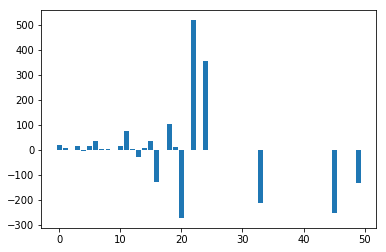

In [18]:
grouped_by_range = df.groupby(pd.cut(df['_range'], bins=50))
print(grouped_by_range.pnl.mean())
plt.bar(range(len(grouped_by_range.pnl.mean())),grouped_by_range.pnl.mean())
# _range选择在350以内

<Container object of 50 artists>

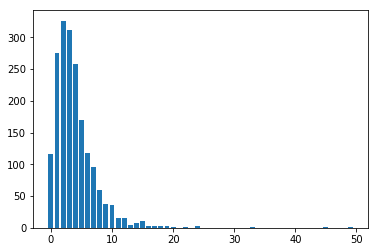

In [19]:
plt.bar(range(len(grouped_by_range.pnl.mean())),grouped_by_range.pnl.count())

_std
(8.593, 16.925]        19.147059
(16.925, 24.859]        7.867036
(24.859, 32.794]        0.910082
(32.794, 40.729]       10.341463
(40.729, 48.663]       10.215859
(48.663, 56.598]       17.154412
(56.598, 64.532]       16.826531
(64.532, 72.467]      -11.523077
(72.467, 80.402]        7.000000
(80.402, 88.336]       26.323529
(88.336, 96.271]       56.227273
(96.271, 104.205]       2.538462
(104.205, 112.14]      76.125000
(112.14, 120.075]      28.833333
(120.075, 128.009]      2.333333
(128.009, 135.944]    115.857143
(135.944, 143.878]   -136.500000
(143.878, 151.813]    120.000000
(151.813, 159.748]    176.500000
(159.748, 167.682]    -58.000000
(167.682, 175.617]           NaN
(175.617, 183.551]           NaN
(183.551, 191.486]           NaN
(191.486, 199.421]           NaN
(199.421, 207.355]           NaN
(207.355, 215.29]     200.000000
(215.29, 223.224]     160.000000
(223.224, 231.159]           NaN
(231.159, 239.094]           NaN
(239.094, 247.028]           NaN
(247.

<Container object of 50 artists>

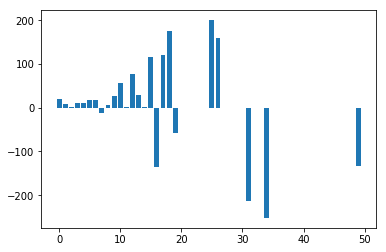

In [22]:
grouped_by_std = df.groupby(pd.cut(df['_std'], bins=50))
print(grouped_by_std.pnl.mean())
plt.bar(range(len(grouped_by_std.pnl.mean())),grouped_by_std.pnl.mean())
# _std选择在120以内

<Container object of 50 artists>

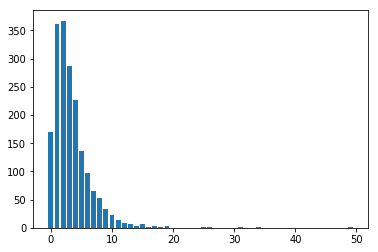

In [23]:
plt.bar(range(len(grouped_by_std.pnl.mean())),grouped_by_std.pnl.count())